# (Beginning of Loading Data and Models)

# Loading Images

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
import os
import ast
from torch import nn
import torch
import torchvision
from skimage import io

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
def check_image_dimensions(folder_path):
    # Check if the folder path exists
    if not os.path.exists(folder_path):
        print("Folder path does not exist.")
        return

    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Flag to track if all images have the correct dimensions
    all_correct_dimensions = True

    # Iterate through each file
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)

        # Check if the file is an image
        if os.path.isfile(file_path) and any(file_name.lower().endswith(image_ext) for image_ext in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']):
            try:
                # Open the image
                with Image.open(file_path) as img:
                    # Get the dimensions
                    width, height = img.size
                    # Check if dimensions are not 1280x720
                    if width != 1280 or height != 720:
                        all_correct_dimensions = False
                        print(f"Image: {file_name} does not have dimensions 1280x720")
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")
        else:
            print(f"{file_name} is not an image file.")

    # If all images have correct dimensions
    if all_correct_dimensions:
        print("All images have dimensions 1280x720.")
    else:
        print("Not all images have dimensions 1280x720.")

# Example usage:
folder_path = "/content/drive/MyDrive/395FinalProject/Dataset/images2"
check_image_dimensions(folder_path)

new is not an image file.
All images have dimensions 1280x720.


In [15]:
path = '/content/drive/MyDrive/395FinalProject/Dataset/images2/'

# Create a new directory to save resized images
os.makedirs(os.path.join(path, 'new'), exist_ok=True)

for item in os.listdir(path):
    if os.path.isfile(os.path.join(path, item)):
        im = Image.open(os.path.join(path, item))
        # Convert image to grayscale
        im = im.convert('L')
        f, e = os.path.splitext(item)
        imResize = im.resize((240,140), Image.LANCZOS)
        imResize.save(os.path.join(path, 'new', item), 'JPEG')


In [3]:
path = "/content/drive/MyDrive/395FinalProject/Dataset/images2/new/"

img_names = os.listdir(path)

images = np.empty(shape = (3784, 140, 240))
for idx, name in enumerate(img_names):
    img_name = path + name
    # Use you favourite library to load the image
    image = plt.imread(img_name)
    images[idx] = image

# Loading CSV classifications + Train-test Split

In [4]:
# Concatenate the DataFrames in the game_clips list into a single DataFrame
# combined18_df = pd.concat([game1, game8], ignore_index=True)

# Convert to csv
# combined18_df.to_csv('game18.csv', index=False)

df = pd.read_csv('/content/drive/MyDrive/395FinalProject/Dataset/game182_fixed.csv')

# combined19_df['image_data'][0]

# Apply a lambda function to convert each entry to a NumPy array
# combined19_df['image_data'] = combined19_df['image_data'].apply(lambda x: np.array(ast.literal_eval(x)))

# Print the 'image_data' column
# print(combined19_df['image_data'])


X = images
y = df['shot']

#print(y)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)


(3405, 140, 240)
(379, 140, 240)
(3405,)
(379,)


# Model

In [5]:
class my_net(nn.Module):

    ## Constructor commands
    def __init__(self):
        super(my_net, self).__init__()

        ## The network will flatten each 28x28 image to 784 features
        self.flatten = nn.Flatten()

        ## It will apply the following functions sequentially
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(33600, 8192),
            nn.ReLU(),
            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    ## Function to generate predictions
    def forward(self, x):

        ## First it flattens x (this is flatten() as we defined above)
        x = self.flatten(x)

        ## Then it applies "linear_relu_stack()" (also defined above)
        scores = self.linear_relu_stack(x)

        ## The output of the final layer is returned
        return scores


# Initialize Cost, Model, Train_loader

In [6]:
train_X_tensor = torch.Tensor(train_X)
train_y_tensor = torch.Tensor(train_y)

## Training parameters
epochs = 5
lrate = 0.01
bsize = 100

## Cost Function (cross entropy loss since the outcome is categorical)
cost_fn = nn.CrossEntropyLoss()

## Initialize the model
net = my_net()

## Set up the optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(train_X_tensor, train_y_tensor), batch_size=bsize)


# Running Epochs for Cost Tracking (RAM Issue)

In [7]:
from tqdm import tqdm  # Import tqdm for progress bars

# Initial values for cost tracking
track_cost = np.zeros(epochs)
cur_cost = 0.0

# Loop through the data with tqdm for progress bars
for epoch in range(epochs):

    cur_cost = 0.0
    correct = 0.0

    # Use tqdm to add progress bars to the inner loop
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch', leave=False)):

        # This is the input tensor and labels tensor for the current batch
        inputs, labels = data

        # This clears the gradient calculated using the previous batch
        optimizer.zero_grad()

        # This is the forward pass
        # The input tensor is given to the network to get outputs
        outputs = net(inputs)

        labels = labels.long()

        # This calculates the cost for the current batch
        # nn.Softmax is used because net outputs prediction scores and our cost function expects probabilities and labels
        cost = cost_fn(nn.Softmax(dim=1)(outputs), labels)

        # This is the backward pass
        # The gradient is computed starting from the cost function
        cost.backward()
        optimizer.step()

        print(f"Cost: {cost.item()}")
        # Track the current cost (accumulating across batches)
        cur_cost += cost.item()

    # Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print(f"Epoch: {epoch} Cost: {cur_cost}")  # Uncomment this if you want printed updates


Epoch 1/5:   3%|▎         | 1/35 [00:03<01:52,  3.32s/batch]

Cost: 2.331085443496704


Epoch 1/5:   6%|▌         | 2/35 [00:06<01:41,  3.07s/batch]

Cost: 2.4317221641540527


Epoch 1/5:   9%|▊         | 3/35 [00:09<01:37,  3.06s/batch]

Cost: 2.2811508178710938


Epoch 1/5:  11%|█▏        | 4/35 [00:13<01:47,  3.48s/batch]

Cost: 2.3011507987976074


Epoch 1/5:  14%|█▍        | 5/35 [00:16<01:38,  3.28s/batch]

Cost: 2.331150770187378


Epoch 1/5:  17%|█▋        | 6/35 [00:19<01:31,  3.15s/batch]

Cost: 2.26115083694458


Epoch 1/5:  20%|██        | 7/35 [00:22<01:33,  3.34s/batch]

Cost: 2.271150827407837


Epoch 1/5:  23%|██▎       | 8/35 [00:26<01:33,  3.47s/batch]

Cost: 2.2911508083343506


Epoch 1/5:  26%|██▌       | 9/35 [00:30<01:30,  3.49s/batch]

Cost: 2.2811508178710938


Epoch 1/5:  29%|██▊       | 10/35 [00:33<01:21,  3.28s/batch]

Cost: 2.2811508178710938


Epoch 1/5:  31%|███▏      | 11/35 [00:37<01:28,  3.68s/batch]

Cost: 2.321150779724121


Epoch 1/5:  34%|███▍      | 12/35 [00:41<01:23,  3.64s/batch]

Cost: 2.3511507511138916


Epoch 1/5:  37%|███▋      | 13/35 [00:44<01:21,  3.70s/batch]

Cost: 2.2511508464813232


Epoch 1/5:  40%|████      | 14/35 [00:47<01:12,  3.43s/batch]

Cost: 2.3111507892608643


Epoch 1/5:  43%|████▎     | 15/35 [00:50<01:04,  3.24s/batch]

Cost: 2.2811508178710938


Epoch 1/5:  46%|████▌     | 16/35 [00:53<00:59,  3.11s/batch]

Cost: 2.3511507511138916


Epoch 1/5:  49%|████▊     | 17/35 [00:57<00:59,  3.33s/batch]

Cost: 2.2311508655548096


Epoch 1/5:  51%|█████▏    | 18/35 [01:00<00:57,  3.40s/batch]

Cost: 2.3411507606506348


Epoch 1/5:  54%|█████▍    | 19/35 [01:03<00:52,  3.25s/batch]

Cost: 2.331150770187378


Epoch 1/5:  57%|█████▋    | 20/35 [01:06<00:46,  3.13s/batch]

Cost: 2.331150770187378


Epoch 1/5:  60%|██████    | 21/35 [01:09<00:42,  3.04s/batch]

Cost: 2.321150779724121


Epoch 1/5:  63%|██████▎   | 22/35 [01:13<00:43,  3.37s/batch]

Cost: 2.2311508655548096


Epoch 1/5:  66%|██████▌   | 23/35 [01:16<00:40,  3.38s/batch]

Cost: 2.2411508560180664


Epoch 1/5:  69%|██████▊   | 24/35 [01:19<00:35,  3.26s/batch]

Cost: 2.2911508083343506


Epoch 1/5:  71%|███████▏  | 25/35 [01:22<00:31,  3.16s/batch]

Cost: 2.3111507892608643


Epoch 1/5:  74%|███████▍  | 26/35 [01:27<00:31,  3.46s/batch]

Cost: 2.271150827407837


Epoch 1/5:  77%|███████▋  | 27/35 [01:31<00:29,  3.71s/batch]

Cost: 2.331150770187378


Epoch 1/5:  80%|████████  | 28/35 [01:34<00:24,  3.46s/batch]

Cost: 2.2911508083343506


Epoch 1/5:  83%|████████▎ | 29/35 [01:37<00:19,  3.28s/batch]

Cost: 2.211150884628296


Epoch 1/5:  86%|████████▌ | 30/35 [01:39<00:15,  3.17s/batch]

Cost: 2.3011507987976074


Epoch 1/5:  89%|████████▊ | 31/35 [01:43<00:13,  3.43s/batch]

Cost: 2.201150894165039


Epoch 1/5:  91%|█████████▏| 32/35 [01:47<00:10,  3.40s/batch]

Cost: 2.321150779724121


Epoch 1/5:  94%|█████████▍| 33/35 [01:50<00:06,  3.22s/batch]

Cost: 2.3411507606506348


Epoch 1/5:  97%|█████████▋| 34/35 [01:52<00:03,  3.10s/batch]

Cost: 2.2211508750915527


Cost: 2.2611501216888428
Epoch: 0 Cost: 80.31078362464905


Epoch 2/5:   3%|▎         | 1/35 [00:03<01:56,  3.41s/batch]

Cost: 2.331150770187378


Epoch 2/5:   6%|▌         | 2/35 [00:07<01:59,  3.63s/batch]

Cost: 2.26115083694458


Epoch 2/5:   9%|▊         | 3/35 [00:10<01:45,  3.29s/batch]

Cost: 2.2811508178710938


Epoch 2/5:  11%|█▏        | 4/35 [00:12<01:36,  3.11s/batch]

Cost: 2.3011507987976074


Epoch 2/5:  14%|█▍        | 5/35 [00:15<01:29,  2.98s/batch]

Cost: 2.331150770187378


Epoch 2/5:  17%|█▋        | 6/35 [00:19<01:33,  3.23s/batch]

Cost: 2.26115083694458


Epoch 2/5:  20%|██        | 7/35 [00:22<01:33,  3.34s/batch]

Cost: 2.271150827407837


Epoch 2/5:  23%|██▎       | 8/35 [00:25<01:25,  3.18s/batch]

Cost: 2.2911508083343506


Epoch 2/5:  26%|██▌       | 9/35 [00:28<01:19,  3.06s/batch]

Cost: 2.2811508178710938


Epoch 2/5:  29%|██▊       | 10/35 [00:31<01:14,  2.99s/batch]

Cost: 2.2811508178710938


Epoch 2/5:  31%|███▏      | 11/35 [00:35<01:19,  3.30s/batch]

Cost: 2.321150779724121


Epoch 2/5:  34%|███▍      | 12/35 [00:38<01:15,  3.30s/batch]

Cost: 2.3511507511138916


Epoch 2/5:  37%|███▋      | 13/35 [00:41<01:09,  3.15s/batch]

Cost: 2.2511508464813232


Epoch 2/5:  40%|████      | 14/35 [00:44<01:04,  3.06s/batch]

Cost: 2.3111507892608643


Epoch 2/5:  43%|████▎     | 15/35 [00:47<00:59,  3.00s/batch]

Cost: 2.2811508178710938


Epoch 2/5:  46%|████▌     | 16/35 [00:51<01:03,  3.33s/batch]

Cost: 2.3511507511138916


Epoch 2/5:  49%|████▊     | 17/35 [00:54<00:58,  3.26s/batch]

Cost: 2.2311508655548096


Epoch 2/5:  51%|█████▏    | 18/35 [00:57<00:53,  3.13s/batch]

Cost: 2.3411507606506348


Epoch 2/5:  54%|█████▍    | 19/35 [01:00<00:48,  3.03s/batch]

Cost: 2.331150770187378


Epoch 2/5:  57%|█████▋    | 20/35 [01:03<00:45,  3.03s/batch]

Cost: 2.331150770187378


Epoch 2/5:  60%|██████    | 21/35 [01:07<00:46,  3.36s/batch]

Cost: 2.321150779724121


Epoch 2/5:  63%|██████▎   | 22/35 [01:10<00:42,  3.26s/batch]

Cost: 2.2311508655548096


Epoch 2/5:  66%|██████▌   | 23/35 [01:13<00:37,  3.12s/batch]

Cost: 2.2411508560180664


Epoch 2/5:  69%|██████▊   | 24/35 [01:15<00:33,  3.02s/batch]

Cost: 2.2911508083343506


Epoch 2/5:  71%|███████▏  | 25/35 [01:18<00:30,  3.06s/batch]

Cost: 2.3111507892608643


Epoch 2/5:  74%|███████▍  | 26/35 [01:23<00:30,  3.40s/batch]

Cost: 2.271150827407837


Epoch 2/5:  77%|███████▋  | 27/35 [01:25<00:25,  3.23s/batch]

Cost: 2.331150770187378


Epoch 2/5:  80%|████████  | 28/35 [01:28<00:21,  3.10s/batch]

Cost: 2.2911508083343506


Epoch 2/5:  83%|████████▎ | 29/35 [01:31<00:18,  3.03s/batch]

Cost: 2.211150884628296


Epoch 2/5:  86%|████████▌ | 30/35 [01:35<00:15,  3.16s/batch]

Cost: 2.3011507987976074


Epoch 2/5:  89%|████████▊ | 31/35 [01:38<00:13,  3.35s/batch]

Cost: 2.201150894165039


Epoch 2/5:  91%|█████████▏| 32/35 [01:42<00:10,  3.38s/batch]

Cost: 2.321150779724121


Epoch 2/5:  94%|█████████▍| 33/35 [01:46<00:07,  3.59s/batch]

Cost: 2.3411507606506348


Epoch 2/5:  97%|█████████▋| 34/35 [01:49<00:03,  3.53s/batch]

Cost: 2.2211508750915527


Cost: 2.2611501216888428
Epoch: 1 Cost: 80.14027762413025


Epoch 3/5:   3%|▎         | 1/35 [00:03<01:53,  3.34s/batch]

Cost: 2.331150770187378


Epoch 3/5:   6%|▌         | 2/35 [00:06<01:40,  3.03s/batch]

Cost: 2.26115083694458


Epoch 3/5:   9%|▊         | 3/35 [00:08<01:33,  2.93s/batch]

Cost: 2.2811508178710938


Epoch 3/5:  11%|█▏        | 4/35 [00:11<01:28,  2.85s/batch]

Cost: 2.3011507987976074


Epoch 3/5:  14%|█▍        | 5/35 [00:15<01:39,  3.30s/batch]

Cost: 2.331150770187378


Epoch 3/5:  17%|█▋        | 6/35 [00:19<01:35,  3.29s/batch]

Cost: 2.26115083694458


Epoch 3/5:  20%|██        | 7/35 [00:21<01:27,  3.12s/batch]

Cost: 2.271150827407837


Epoch 3/5:  23%|██▎       | 8/35 [00:24<01:21,  3.01s/batch]

Cost: 2.2911508083343506


Epoch 3/5:  26%|██▌       | 9/35 [00:27<01:17,  2.96s/batch]

Cost: 2.2811508178710938


Epoch 3/5:  29%|██▊       | 10/35 [00:31<01:22,  3.32s/batch]

Cost: 2.2811508178710938


Epoch 3/5:  31%|███▏      | 11/35 [00:34<01:17,  3.22s/batch]

Cost: 2.321150779724121


Epoch 3/5:  34%|███▍      | 12/35 [00:37<01:10,  3.08s/batch]

Cost: 2.3511507511138916


Epoch 3/5:  37%|███▋      | 13/35 [00:40<01:05,  2.98s/batch]

Cost: 2.2511508464813232


Epoch 3/5:  40%|████      | 14/35 [00:43<01:02,  2.99s/batch]

Cost: 2.3111507892608643


Epoch 3/5:  43%|████▎     | 15/35 [00:47<01:06,  3.34s/batch]

Cost: 2.2811508178710938


Epoch 3/5:  46%|████▌     | 16/35 [00:50<01:00,  3.17s/batch]

Cost: 2.3511507511138916


Epoch 3/5:  49%|████▊     | 17/35 [00:52<00:55,  3.06s/batch]

Cost: 2.2311508655548096


Epoch 3/5:  51%|█████▏    | 18/35 [00:55<00:50,  2.96s/batch]

Cost: 2.3411507606506348


Epoch 3/5:  54%|█████▍    | 19/35 [00:58<00:48,  3.04s/batch]

Cost: 2.331150770187378


Epoch 3/5:  57%|█████▋    | 20/35 [01:02<00:50,  3.35s/batch]

Cost: 2.331150770187378


Epoch 3/5:  60%|██████    | 21/35 [01:05<00:44,  3.18s/batch]

Cost: 2.321150779724121


Epoch 3/5:  63%|██████▎   | 22/35 [01:08<00:39,  3.06s/batch]

Cost: 2.2311508655548096


Epoch 3/5:  66%|██████▌   | 23/35 [01:11<00:35,  2.97s/batch]

Cost: 2.2411508560180664


Epoch 3/5:  69%|██████▊   | 24/35 [01:17<00:44,  4.06s/batch]

Cost: 2.2911508083343506


Epoch 3/5:  71%|███████▏  | 25/35 [01:21<00:38,  3.89s/batch]

Cost: 2.3111507892608643


Epoch 3/5:  74%|███████▍  | 26/35 [01:24<00:31,  3.55s/batch]

Cost: 2.271150827407837


Epoch 3/5:  77%|███████▋  | 27/35 [01:26<00:26,  3.32s/batch]

Cost: 2.331150770187378


Epoch 3/5:  80%|████████  | 28/35 [01:29<00:22,  3.17s/batch]

Cost: 2.2911508083343506


Epoch 3/5:  83%|████████▎ | 29/35 [01:33<00:20,  3.42s/batch]

Cost: 2.211150884628296


Epoch 3/5:  86%|████████▌ | 30/35 [01:36<00:16,  3.38s/batch]

Cost: 2.3011507987976074


Epoch 3/5:  89%|████████▊ | 31/35 [01:39<00:12,  3.20s/batch]

Cost: 2.201150894165039


Epoch 3/5:  91%|█████████▏| 32/35 [01:42<00:09,  3.07s/batch]

Cost: 2.321150779724121


Epoch 3/5:  94%|█████████▍| 33/35 [01:45<00:05,  2.99s/batch]

Cost: 2.3411507606506348


Epoch 3/5:  97%|█████████▋| 34/35 [01:49<00:03,  3.33s/batch]

Cost: 2.2211508750915527


Cost: 2.2611501216888428
Epoch: 2 Cost: 80.14027762413025


Epoch 4/5:   3%|▎         | 1/35 [00:02<01:34,  2.79s/batch]

Cost: 2.331150770187378


Epoch 4/5:   6%|▌         | 2/35 [00:05<01:31,  2.77s/batch]

Cost: 2.26115083694458


Epoch 4/5:   9%|▊         | 3/35 [00:08<01:28,  2.77s/batch]

Cost: 2.2811508178710938


Epoch 4/5:  11%|█▏        | 4/35 [00:11<01:34,  3.06s/batch]

Cost: 2.3011507987976074


Epoch 4/5:  14%|█▍        | 5/35 [00:15<01:38,  3.28s/batch]

Cost: 2.331150770187378


Epoch 4/5:  17%|█▋        | 6/35 [00:18<01:29,  3.10s/batch]

Cost: 2.26115083694458


Epoch 4/5:  20%|██        | 7/35 [00:21<01:23,  2.99s/batch]

Cost: 2.271150827407837


Epoch 4/5:  23%|██▎       | 8/35 [00:23<01:18,  2.92s/batch]

Cost: 2.2911508083343506


Epoch 4/5:  26%|██▌       | 9/35 [00:27<01:22,  3.16s/batch]

Cost: 2.2811508178710938


Epoch 4/5:  29%|██▊       | 10/35 [00:31<01:22,  3.29s/batch]

Cost: 2.2811508178710938


Epoch 4/5:  31%|███▏      | 11/35 [00:33<01:15,  3.13s/batch]

Cost: 2.321150779724121


Epoch 4/5:  34%|███▍      | 12/35 [00:36<01:09,  3.02s/batch]

Cost: 2.3511507511138916


Epoch 4/5:  37%|███▋      | 13/35 [00:39<01:04,  2.94s/batch]

Cost: 2.2511508464813232


Epoch 4/5:  40%|████      | 14/35 [00:43<01:08,  3.24s/batch]

Cost: 2.3111507892608643


Epoch 4/5:  43%|████▎     | 15/35 [00:46<01:05,  3.29s/batch]

Cost: 2.2811508178710938


Epoch 4/5:  46%|████▌     | 16/35 [00:49<00:59,  3.12s/batch]

Cost: 2.3511507511138916


Epoch 4/5:  49%|████▊     | 17/35 [00:52<00:54,  3.02s/batch]

Cost: 2.2311508655548096


Epoch 4/5:  51%|█████▏    | 18/35 [00:54<00:50,  2.96s/batch]

Cost: 2.3411507606506348


Epoch 4/5:  54%|█████▍    | 19/35 [00:59<00:52,  3.28s/batch]

Cost: 2.331150770187378


Epoch 4/5:  57%|█████▋    | 20/35 [01:02<00:49,  3.27s/batch]

Cost: 2.331150770187378


Epoch 4/5:  60%|██████    | 21/35 [01:05<00:43,  3.13s/batch]

Cost: 2.321150779724121


Epoch 4/5:  63%|██████▎   | 22/35 [01:07<00:39,  3.03s/batch]

Cost: 2.2311508655548096


Epoch 4/5:  66%|██████▌   | 23/35 [01:10<00:35,  2.99s/batch]

Cost: 2.2411508560180664


Epoch 4/5:  69%|██████▊   | 24/35 [01:14<00:36,  3.32s/batch]

Cost: 2.2911508083343506


Epoch 4/5:  71%|███████▏  | 25/35 [01:17<00:32,  3.23s/batch]

Cost: 2.3111507892608643


Epoch 4/5:  74%|███████▍  | 26/35 [01:20<00:27,  3.11s/batch]

Cost: 2.271150827407837


Epoch 4/5:  77%|███████▋  | 27/35 [01:32<00:44,  5.57s/batch]

Cost: 2.331150770187378


Epoch 4/5:  80%|████████  | 28/35 [01:39<00:42,  6.13s/batch]

Cost: 2.2911508083343506


Epoch 4/5:  83%|████████▎ | 29/35 [01:42<00:30,  5.15s/batch]

Cost: 2.211150884628296


Epoch 4/5:  86%|████████▌ | 30/35 [01:45<00:22,  4.45s/batch]

Cost: 2.3011507987976074


Epoch 4/5:  89%|████████▊ | 31/35 [01:47<00:15,  3.96s/batch]

Cost: 2.201150894165039


Epoch 4/5:  91%|█████████▏| 32/35 [01:52<00:12,  4.01s/batch]

Cost: 2.321150779724121


Epoch 4/5:  94%|█████████▍| 33/35 [01:55<00:07,  3.73s/batch]

Cost: 2.3411507606506348


Epoch 4/5:  97%|█████████▋| 34/35 [01:58<00:03,  3.54s/batch]

Cost: 2.2211508750915527


Cost: 2.2611501216888428
Epoch: 3 Cost: 80.14027762413025


Epoch 5/5:   3%|▎         | 1/35 [00:04<02:21,  4.17s/batch]

Cost: 2.331150770187378


Epoch 5/5:   6%|▌         | 2/35 [00:08<02:16,  4.13s/batch]

Cost: 2.26115083694458


Epoch 5/5:   9%|▊         | 3/35 [00:11<01:52,  3.51s/batch]

Cost: 2.2811508178710938


Epoch 5/5:  11%|█▏        | 4/35 [00:13<01:39,  3.20s/batch]

Cost: 2.3011507987976074


Epoch 5/5:  14%|█▍        | 5/35 [00:16<01:31,  3.05s/batch]

Cost: 2.331150770187378


Epoch 5/5:  17%|█▋        | 6/35 [00:19<01:30,  3.13s/batch]

Cost: 2.26115083694458


Epoch 5/5:  20%|██        | 7/35 [00:23<01:35,  3.42s/batch]

Cost: 2.271150827407837


Epoch 5/5:  23%|██▎       | 8/35 [00:26<01:26,  3.21s/batch]

Cost: 2.2911508083343506


Epoch 5/5:  26%|██▌       | 9/35 [00:29<01:19,  3.07s/batch]

Cost: 2.2811508178710938


Epoch 5/5:  29%|██▊       | 10/35 [00:32<01:14,  2.97s/batch]

Cost: 2.2811508178710938


Epoch 5/5:  31%|███▏      | 11/35 [00:35<01:14,  3.10s/batch]

Cost: 2.321150779724121


Epoch 5/5:  34%|███▍      | 12/35 [00:39<01:15,  3.30s/batch]

Cost: 2.3511507511138916


Epoch 5/5:  37%|███▋      | 13/35 [00:42<01:08,  3.13s/batch]

Cost: 2.2511508464813232


Epoch 5/5:  40%|████      | 14/35 [00:44<01:03,  3.01s/batch]

Cost: 2.3111507892608643


Epoch 5/5:  43%|████▎     | 15/35 [00:47<00:58,  2.93s/batch]

Cost: 2.2811508178710938


Epoch 5/5:  46%|████▌     | 16/35 [00:51<00:59,  3.11s/batch]

Cost: 2.3511507511138916


Epoch 5/5:  49%|████▊     | 17/35 [00:54<00:58,  3.26s/batch]

Cost: 2.2311508655548096


Epoch 5/5:  51%|█████▏    | 18/35 [00:57<00:52,  3.10s/batch]

Cost: 2.3411507606506348


Epoch 5/5:  54%|█████▍    | 19/35 [01:00<00:47,  2.99s/batch]

Cost: 2.331150770187378


Epoch 5/5:  57%|█████▋    | 20/35 [01:02<00:43,  2.93s/batch]

Cost: 2.331150770187378


Epoch 5/5:  60%|██████    | 21/35 [01:06<00:44,  3.17s/batch]

Cost: 2.321150779724121


Epoch 5/5:  63%|██████▎   | 22/35 [01:10<00:42,  3.27s/batch]

Cost: 2.2311508655548096


Epoch 5/5:  66%|██████▌   | 23/35 [01:12<00:37,  3.13s/batch]

Cost: 2.2411508560180664


Epoch 5/5:  69%|██████▊   | 24/35 [01:15<00:33,  3.01s/batch]

Cost: 2.2911508083343506


Epoch 5/5:  71%|███████▏  | 25/35 [01:18<00:29,  2.94s/batch]

Cost: 2.3111507892608643


Epoch 5/5:  74%|███████▍  | 26/35 [01:22<00:29,  3.22s/batch]

Cost: 2.271150827407837


Epoch 5/5:  77%|███████▋  | 27/35 [01:25<00:25,  3.25s/batch]

Cost: 2.331150770187378


Epoch 5/5:  80%|████████  | 28/35 [01:28<00:21,  3.09s/batch]

Cost: 2.2911508083343506


Epoch 5/5:  83%|████████▎ | 29/35 [01:31<00:17,  3.00s/batch]

Cost: 2.211150884628296


Epoch 5/5:  86%|████████▌ | 30/35 [01:33<00:14,  2.93s/batch]

Cost: 2.3011507987976074


Epoch 5/5:  89%|████████▊ | 31/35 [01:37<00:13,  3.28s/batch]

Cost: 2.201150894165039


Epoch 5/5:  91%|█████████▏| 32/35 [01:41<00:09,  3.25s/batch]

Cost: 2.321150779724121


Epoch 5/5:  94%|█████████▍| 33/35 [01:43<00:06,  3.11s/batch]

Cost: 2.3411507606506348


Epoch 5/5:  97%|█████████▋| 34/35 [01:46<00:03,  3.01s/batch]

Cost: 2.2211508750915527


Cost: 2.2611501216888428
Epoch: 4 Cost: 80.14027762413025


# Classification Accuracy

In [8]:
# Initialize objects for counting correct/total
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    # Use tqdm for progress bar
    for data in tqdm(train_loader, desc='Evaluation', unit='batch', leave=False):
        # Current batch of data
        images, labels = data

        # pass each batch into the network
        outputs = net(images)

        # the class with the maximum score is what will be the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # add size of the current batch
        total += labels.size(0)

        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

# Calculate and print the proportion correct
print(correct/total)

0.17063142437591777


# Classification Accuracy on Test Set

In [12]:
# Convert Pandas Series to NumPy array
test_y_array = test_y.to_numpy()

# Convert NumPy array to PyTorch tensor
test_y_tensor = torch.Tensor(test_y_array)

### Convert to numpy array then reshape
test_unflattened = test_X.reshape(len(test_y), 240, 140, 1)

## Convert test images into a tensor
test_tensor = torch.from_numpy(test_unflattened)

## Combine X and y tensors into a TensorDataset and DataLoader
test_loader = DataLoader(TensorDataset(test_tensor.type(torch.FloatTensor), test_y_tensor.type(torch.LongTensor)), batch_size=bsize)

## Repeat evaluation loop suing the test data
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct/total)

0.18997361477572558


# Distribution Graphics

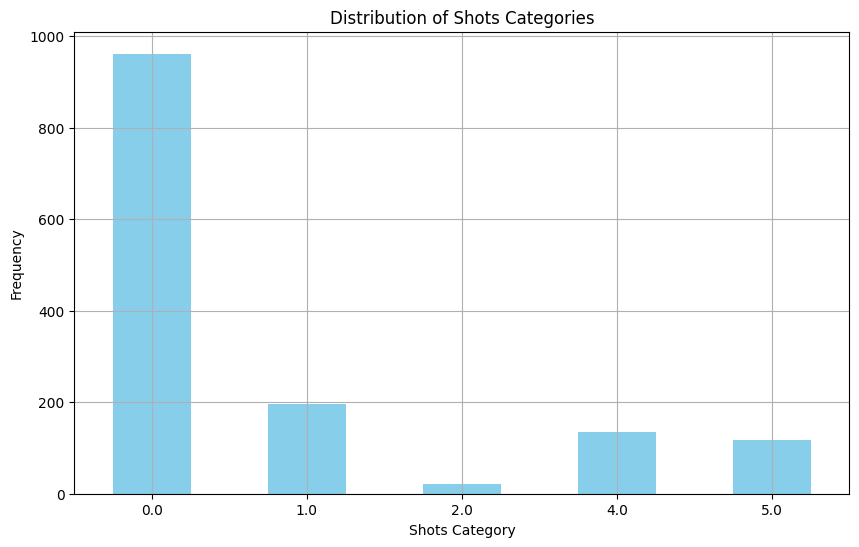

Percentage of frames in each category (shot):
shot
0.0    67.225716
1.0    13.766597
2.0     1.467505
4.0     9.364081
5.0     8.176101
Name: count, dtype: float64


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/395FinalProject/Dataset/game1.csv'
path8 = '/content/drive/MyDrive/395FinalProject/Dataset/game8.csv'
game1 = pd.read_csv(path)
game8 = pd.read_csv(path8)

def plot_shots_distribution(game):
    # Assuming 'shots' is the column of interest
    shots_counts = game['shot'].value_counts().sort_index()

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    shots_counts.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Shots Categories')
    plt.xlabel('Shots Category')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.show()

# Calculating and displaying the percentage of frames in each class
    total_counts = game['shot'].count()
    percentage = (shots_counts / total_counts) * 100
    print("Percentage of frames in each category (shot):")
    print(percentage)

plot_shots_distribution(game8)

# Example function call (you will replace '001' with your actual game number to use this function):
# plot_shots_distribution_and_stats('001')
